In [11]:
import os
import time
import subprocess


opend_path = r"moomoo_OpenD_9.6.5618_Windows\OpenD.exe"

def start_opend_headless():
    try:
        if os.name == 'nt': # Windows
                process = subprocess.Popen([opend_path], creationflags=subprocess.CREATE_NEW_CONSOLE)
        else: # Linux/macOS
            process = subprocess.Popen([opend_path])
        print(f"OpenD started with PID: {process.pid}")
        return process
    except FileNotFoundError:
        print(f"Error: OpenD executable not found at {opend_path}")
        return None
opend_process = start_opend_headless()
if opend_process:
        time.sleep(5) # Wait for 5 seconds to ensure OpenD starts properly
        print("Connecting to OpenD via API...")

# launch_moomoo_openD()

OpenD started with PID: 24572
2026-01-05 15:40:26,605 | 31248 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=3, host=127.0.0.1, port=11111, user_id=102089581
2026-01-05 15:40:26,643 | 31248 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=4, host=127.0.0.1, port=11111, user_id=102089581
Connecting to OpenD via API...


In [12]:
from dotenv import load_dotenv
import moomoo as moomoo
from moomoo.trade.open_trade_context import OpenSecTradeContext
import pandas as pd
import yfinance as yf
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import yfinance as yf
from typing import Optional, Dict, List

In [13]:
# Load environment variables from .env file
load_dotenv()

# Pipenv automatically loads KEY_PATH from your .env file
key_path = os.getenv("KEY_PATH")

if not key_path: 
    raise ValueError("KEY_PATH not found. Have you created your .env file?")

# 1. Configure the RSA private key file globally
# This sets the key path for all subsequent contexts.
moomoo.SysConfig.set_init_rsa_file(key_path)

# 2. Create the trade context and enable encryption
# is_encrypt=True tells this specific context to use the key configured above.
trade_ctx = OpenSecTradeContext(
    host='127.0.0.1',
    port=11111,
    is_encrypt=True,
    security_firm="FUTUSG"
    )

def account_list(trade_obj: OpenSecTradeContext):
    ret, data = trade_obj.get_acc_list()
    if ret == moomoo.RET_OK:
        return data
    else:
        raise Exception('get_acc_list error: ', data)

display(account_list(trade_ctx))
acc_list = account_list(trade_ctx)


2026-01-05 15:40:28,294 | 31248 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=5, host=127.0.0.1, port=11111, user_id=102089581


,acc_id,trd_env,acc_type,uni_card_num,card_num,security_firm,sim_acc_type,trdmarket_auth,acc_status
0,283726803662729116,REAL,MARGIN,1008206356731706,1008325099371778,FUTUSG,N/A,"[HK, US, HKCC, SG, HKFUND, USFUND, JP]",ACTIVE
1,1437342,SIMULATE,CASH,N/A,N/A,N/A,STOCK,[HK],ACTIVE


In [14]:
def account_info(trade_obj: OpenSecTradeContext):
    ret, data = trade_obj.accinfo_query(trd_env="REAL",refresh_cache=True,currency="SGD")
    if ret == moomoo.RET_OK:
        return data
    else:
        raise Exception('accinfo_query error: ', data)
display(account_info(trade_ctx))
acc_info = account_info(trade_ctx)

,power,max_power_short,net_cash_power,total_assets,securities_assets,fund_assets,bond_assets,cash,market_val,long_mv,...,au_cash,au_avl_withdrawal_cash,aud_net_cash_power,aud_assets,is_pdt,pdt_seq,beginning_dtbp,remaining_dtbp,dt_call_amount,dt_status
0,0.013437,0.013437,0.0,53734.1505,53654.42,79.74,0.0,0.0,53654.4052,75253.9306,...,N/A,N/A,N/A,0.0,N/A,N/A,N/A,N/A,N/A,N/A


In [15]:
def get_positions(trade_obj: OpenSecTradeContext):
    ret, data = trade_obj.position_list_query(trd_env="REAL",refresh_cache=True)
    if ret == moomoo.RET_OK:
        return data
    else:
        raise Exception('position_list_query error: ', data)
display(get_positions(trade_ctx))
positions = get_positions(trade_ctx)

,code,stock_name,position_market,qty,can_sell_qty,cost_price,cost_price_valid,average_cost,diluted_cost,market_val,...,today_buy_qty,today_buy_val,today_pl_val,today_trd_val,today_sell_qty,today_sell_val,position_side,unrealized_pl,realized_pl,currency
0,US.NVDA270115C250000,NVDA 270115 250.00C,US,-7.0000,-7.0000,18.2000,True,18.2000,18.2000,-12582.50,...,0.0,0.0,0.00,0.0,0.0,0.0,SHORT,157.5000,0.0000,USD
1,US.GRAB270115C7500,GRAB 270115 7.50C,US,-20.0000,-20.0000,0.9575,True,0.9575,0.9575,-1030.00,...,0.0,0.0,0.00,0.0,0.0,0.0,SHORT,885.0000,0.0000,USD
2,US.AMZN260918C280000,AMZN 260918 280.00C,US,-3.0000,-3.0000,12.6000,True,12.6000,12.6000,-3172.50,...,0.0,0.0,0.00,0.0,0.0,0.0,SHORT,607.5000,0.0000,USD
3,US.V,Visa,US,8.0000,8.0000,326.8010,True,342.7940,326.8010,2761.52,...,0.0,0.0,-10.32,0.0,0.0,0.0,LONG,19.1697,127.9438,USD
4,US.SOFI,SoFi Technologies,US,124.0000,124.0000,25.1340,True,25.1340,25.1340,3416.20,...,0.0,0.0,11.16,0.0,0.0,0.0,LONG,299.5500,0.0000,USD
5,US.NVDA270115C230000,NVDA 270115 230.00C,US,7.0000,7.0000,23.5000,True,23.5000,23.5000,16100.00,...,0.0,0.0,0.00,0.0,0.0,0.0,LONG,-350.0000,0.0000,USD
6,US.META,Meta Platforms,US,3.0016,3.0016,648.2840,True,648.8070,648.2840,1952.24,...,0.0,0.0,-0.03,0.0,0.0,0.0,LONG,4.7806,1.5700,USD
7,US.IBIT,iShares Bitcoin Trust,US,20.0000,20.0000,60.8520,True,60.8530,60.8520,1050.20,...,0.0,0.0,31.40,0.0,0.0,0.0,LONG,-166.8500,0.0000,USD
8,US.HIMS,Hims & Hers Health,US,60.0000,60.0000,41.7730,True,41.8450,41.7730,2028.00,...,0.0,0.0,23.40,0.0,0.0,0.0,LONG,-482.6780,4.2785,USD
9,US.GRAB270115C5000,GRAB 270115 5.00C,US,20.0000,20.0000,1.8820,True,1.8820,1.8820,2360.00,...,0.0,0.0,0.00,0.0,0.0,0.0,LONG,-1405.0000,0.0000,USD


In [ ]:
def historical_account_cashflow(trade_obj: OpenSecTradeContext):
    all_cash_flow_data = pd.DataFrame()
    end_date = datetime.strptime('2023-08-07', '%Y-%m-%d')
    current_date = datetime.combine(date.today(), datetime.min.time())
    
    request_count = 0
    start_time = time.time()

    while end_date <= current_date:
        # Rate Limit Check: 20 requests per 30 seconds
        if request_count >= 20:
            elapsed = time.time() - start_time
            if elapsed < 30:
                wait_time = 30 - elapsed + 1 # Add 1s buffer
                print(f"Quota used. Waiting {wait_time:.2f}s...")
                time.sleep(wait_time)
            # Reset window
            request_count = 0
            start_time = time.time()

        date_str = current_date.strftime('%Y-%m-%d')
        ret, data = trade_obj.get_acc_cash_flow(clearing_date=date_str,trd_env="REAL")

        if ret == moomoo.RET_OK:
            if not data.empty:
                all_cash_flow_data = pd.concat([all_cash_flow_data, data], ignore_index=True)
            request_count += 1
            current_date -= timedelta(days=1)

        elif ret == moomoo.RET_ERROR:
            print("Hit limit. Cooling down for 30s...")
            time.sleep(30)
            start_time = time.time()
            request_count = 0
            

    return all_cash_flow_data


cashflow = historical_account_cashflow(trade_ctx)
display(cashflow)


Quota used. Waiting 30.39s...
Quota used. Waiting 30.35s...
Quota used. Waiting 30.45s...
Quota used. Waiting 29.02s...
Quota used. Waiting 27.29s...
Hit limit. Cooling down for 30s...
Quota used. Waiting 30.42s...
Quota used. Waiting 30.51s...
Quota used. Waiting 27.38s...
Hit limit. Cooling down for 30s...
Quota used. Waiting 30.40s...
Quota used. Waiting 30.36s...
Quota used. Waiting 29.16s...
Quota used. Waiting 29.69s...
Quota used. Waiting 30.43s...
Quota used. Waiting 30.39s...
Quota used. Waiting 28.69s...
Quota used. Waiting 28.87s...
Hit limit. Cooling down for 30s...
Quota used. Waiting 30.37s...
Quota used. Waiting 30.44s...
Quota used. Waiting 30.47s...
Quota used. Waiting 30.53s...
Quota used. Waiting 30.46s...
Quota used. Waiting 30.45s...
Quota used. Waiting 30.48s...
Quota used. Waiting 30.39s...
Quota used. Waiting 30.45s...
Quota used. Waiting 30.38s...
Quota used. Waiting 30.19s...
Quota used. Waiting 30.34s...
Quota used. Waiting 30.46s...
Quota used. Waiting 30.50

,cashflow_id,clearing_date,settlement_date,currency,cashflow_type,cashflow_direction,cashflow_amount,cashflow_remark
0,146217,2025-12-30,2025-12-30,USD,Fund Subscription,OUT,-0.39,Fund Subscription#CSOP USD Money Market Fund
1,238932,2025-12-29,2025-12-29,USD,Cash Dividend,IN,0.55,BMNR 55.00000000 SHARES DIVIDENDS 0.01000000 U...
2,246745,2025-12-29,2025-12-29,USD,Dividend Tax,OUT,-0.16,BMNR 55.00000000 SHARES WITHHOLDING TAX -0.003...
3,173876,2025-12-24,2025-12-24,USD,Fund Subscription,OUT,-0.03,Fund Subscription#CSOP USD Money Market Fund
4,241895,2025-12-23,2025-12-23,USD,Dividend Tax,OUT,-0.47,META 3.00000000 SHARES WITHHOLDING TAX -0.1574...
...,...,...,...,...,...,...,...,...
521,84337,2023-08-07,2023-08-07,SGD,Others,IN,20.00,Coupon Deposit
522,84338,2023-08-07,2023-08-07,SGD,Others,IN,20.00,Coupon Deposit
523,84339,2023-08-07,2023-08-07,SGD,Others,IN,20.00,Coupon Deposit
524,84340,2023-08-07,2023-08-07,SGD,Others,IN,5.00,Coupon Deposit


In [90]:
def get_historical_orders(trade_obj: OpenSecTradeContext):
    ret, data = trade_obj.history_order_list_query(start="2023-08-07 00:00:00",end=datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    if ret == moomoo.RET_OK:
        return data
    else:
        raise Exception('history_order_list_query error: ', data)

historical_orders = get_historical_orders(trade_ctx)
trade_ctx.close()
opend_process.terminate()

display(historical_orders)

,code,stock_name,order_market,trd_side,order_type,order_status,order_id,qty,price,create_time,...,last_err_msg,remark,time_in_force,fill_outside_rth,session,aux_price,trail_type,trail_value,trail_spread,currency
0,US.META,Meta Platforms,US,BUY,NORMAL,FILLED_ALL,FS1BCEBC8FC9D27000,0.0016,664.94,2025-12-23 00:00:00,...,,,DAY,False,RTH,N/A,N/A,N/A,N/A,USD
1,US.SOFI,SoFi Technologies,US,BUY,NORMAL,FILLED_ALL,FS1BBFB30B0F6C5000,4.0000,26.50,2025-12-12 11:16:10.755,...,,,DAY,True,ETH,N/A,N/A,N/A,N/A,USD
2,US.META,Meta Platforms,US,BUY,NORMAL,FILLED_ALL,FS1BB69EC3217A1000,1.0000,670.00,2025-12-05 10:01:14.440,...,,,DAY,True,ETH,N/A,N/A,N/A,N/A,USD
3,US.BMNR,Bitmine Immersion Technologies,US,BUY,NORMAL,FILLED_ALL,FS1BB18A88F7EC5000,5.0000,29.30,2025-12-01 11:20:27.682,...,,,DAY,True,ETH,N/A,N/A,N/A,N/A,USD
4,US.META,Meta Platforms,US,BUY,NORMAL,FILLED_ALL,FS1BB174DAA33A1000,1.0000,640.00,2025-12-01 09:45:44.143,...,,,DAY,True,ETH,N/A,N/A,N/A,N/A,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,US.MSFT,Microsoft,US,BUY,NORMAL,FAILED,FS19042EE4116FF000,2.0000,438.00,2024-06-17 04:20:31.882,...,"Insufficient buying power. To proceed, conside...",,DAY,True,ETH,N/A,N/A,N/A,N/A,USD
528,US.MSFT,Microsoft,US,BUY,NORMAL,FAILED,FS19042D770AEFF000,1.0000,420.00,2024-06-17 04:14:18.096,...,"Insufficient buying power. To proceed, conside...",,DAY,True,ETH,N/A,N/A,N/A,N/A,USD
529,US.NVDA,NVIDIA,US,BUY,NORMAL,FAILED,FS19042C305E2FF000,1.0000,132.63,2024-06-17 04:08:43.578,...,"Insufficient buying power. To proceed, conside...",,DAY,True,ETH,N/A,N/A,N/A,N/A,USD
530,US.MSFT,Microsoft,US,BUY,NORMAL,FAILED,FS19042BA60DE16000,1.0000,443.39,2024-06-17 04:06:21.945,...,"Insufficient buying power. To proceed, conside...",,DAY,True,ETH,N/A,N/A,N/A,N/A,USD


In [ ]:
filter_list = ['total_assets','securities_assets', 'fund_assets','bond_assets','cash','pending_asset','frozen_cash','avl_withdrawal_cash','risk_status',
               'us_cash', 'us_avl_withdrawal_cash','usd_net_cash_power','usd_assets',
               'sg_cash', 'sg_avl_withdrawal_cash','sgd_net_cash_power', 'sgd_assets']
acc_info = acc_info[filter_list]


columns_to_round = [
    'total_assets', 'securities_assets', 'fund_assets', 'bond_assets',
    'cash', 'pending_asset', 'frozen_cash', 'avl_withdrawal_cash',
    'us_cash', 'us_avl_withdrawal_cash', 'usd_net_cash_power',
    'usd_assets', 'sg_cash', 'sg_avl_withdrawal_cash',
    'sgd_net_cash_power', 'sgd_assets'
]
acc_info[columns_to_round] = acc_info[columns_to_round].round(3)

display(acc_info)
def get_cash(acc_info: pd.DataFrame) -> float:

    cash_columns = ['fund_assets', 'cash', 'pending_asset', 'frozen_cash', 'avl_withdrawal_cash',]
    return acc_info[cash_columns].sum(axis=1)[0].round(2)
print(get_cash(acc_info))

def get_total_assets(acc_info: pd.DataFrame) -> float:
    return acc_info['total_assets'][0].round(2)
print(get_total_assets(acc_info))

def get_securities_assets(acc_info: pd.DataFrame) -> float:
    return acc_info['securities_assets'][0].round(2)

print(get_securities_assets(acc_info))

def get_bond_assets(acc_info: pd.DataFrame) -> float:
    return acc_info['bond_assets'][0].round(2)
print(get_bond_assets(acc_info))

,total_assets,securities_assets,fund_assets,bond_assets,cash,pending_asset,frozen_cash,avl_withdrawal_cash,risk_status,us_cash,us_avl_withdrawal_cash,usd_net_cash_power,usd_assets,sg_cash,sg_avl_withdrawal_cash,sgd_net_cash_power,sgd_assets
0,53815.496,53735.65,79.85,0.0,0.0,0.0,0.0,0.0,LEVEL5,0.0,0.0,61.338,41704.74,0.0,0.0,0.013,0.01


79.85
53815.5
53735.65
0.0


In [ ]:
pos_filter_col = ['code', 'stock_name', 'position_market', 'qty','diluted_cost','market_val','nominal_price', 'pl_ratio','pl_val','today_pl_val','currency']
positions = positions[pos_filter_col]
rounding_dict = {
    'diluted_cost': 3,
    'market_val': 3,
    'nominal_price': 3,
    'pl_ratio': 3,
    'pl_val': 3,
    'today_pl_val': 3
}
positions = positions.round(rounding_dict)
positions = positions.sort_values(by='market_val', ascending=False).reset_index(drop=True)
positions.rename(columns={'code': 'Symbol',
                          'stock_name':'Name',
                          'position_market':'Market',
                          'qty':'Quantity',
                          'diluted_cost':'Diluted Cost',
                          'market_val':'Market Value',
                          'nominal_price':'Current Price',
                          'pl_ratio':'P/L %',
                          'pl_val':'P/L',
                          'today_pl_val':"Today's P/L",
                          'currency':'Currency'}, inplace=True)
def extract_ticker(code: str) -> str:
    pattern = r"^[A-Z]+\.(?P<ticker>[A-Z0-9]+).*"
    match = re.match(pattern, code)
    if match:
        return match.group("ticker")
    else:
        return None
positions['Symbol'] = positions['Symbol'].apply(extract_ticker)

display(positions)
positions['Market Value'].sum().round(2)

,Symbol,Name,Market,Quantity,Diluted Cost,Market Value,Current Price,P/L %,P/L,Today's P/L,Currency
0,NVDA270115C230000,NVDA 270115 230.00C,US,7.0000,23.500,16100.00,23.000,-2.13,-350.000,0.000,USD
1,GOOG,Alphabet-C,US,25.0000,182.755,7885.50,315.420,72.59,3316.630,2.500,USD
2,AMZN260918C250000,AMZN 260918 250.00C,US,3.0000,21.500,5730.00,19.100,-11.16,-720.000,0.000,USD
3,ASML,ASML Holding,US,4.0000,609.612,4762.00,1190.500,95.29,2323.550,106.880,USD
4,SOFI,SoFi Technologies,US,124.0000,25.134,3414.96,27.540,9.57,298.310,9.920,USD
5,V,Visa,US,8.0000,326.801,2749.44,343.680,5.16,135.034,-22.400,USD
6,AMZN,Amazon,US,11.0000,222.532,2490.95,226.450,1.76,43.100,-0.550,USD
7,ASTS,AST SpaceMobile,US,30.0000,42.711,2472.00,82.400,92.92,1190.683,-32.100,USD
8,GRAB270115C5000,GRAB 270115 5.00C,US,20.0000,1.882,2360.00,1.180,-37.30,-1405.000,0.000,USD
9,HIMS,Hims & Hers Health,US,60.0000,41.773,2035.80,33.930,-18.78,-470.600,31.200,USD


np.float64(41704.19)

In [ ]:
'''
shares = positions[positions['Symbol'].str.len() <= 4]
options = positions[positions['Symbol'].str.len() > 4]
display(shares)
display(options)
'''

"\nshares = positions[positions['Symbol'].str.len() <= 4]\noptions = positions[positions['Symbol'].str.len() > 4]\ndisplay(shares)\ndisplay(options)\n"

In [ ]:
'''
def update_current_share_price(shares: pd.DataFrame) -> pd.DataFrame:
    tickers = shares['Symbol'].dropna().unique().tolist()
    if not tickers:
        return shares
    price_data = yf.download(tickers=tickers, period='2d',
                             interval='1m',
                             progress=False,
                             prepost=True)

    if price_data.empty:
        print("Warning: Could not download share price data.")
        return shares

    # Extract the most recent price for each ticker
    # Forward-fill to propagate the last valid price, then select the last row.
    # This handles cases where some tickers may not have traded in the last minute.
    latest_prices = price_data['Close'].ffill().iloc[-1].round(decimals=3)
    price_map = latest_prices.to_dict() if isinstance(latest_prices, pd.Series) else {tickers[0]: latest_prices}
    shares['Current Price'] = shares['Symbol'].map(price_map)
    return shares
def get_price_from_custom_format(custom_option_string: str) -> Optional[float]:
    """
    Parses a custom option string, finds the contract in the yfinance
    option chain, and returns its last traded price.

    Args:
        custom_option_string: A string in the format "TICKER YYMMDD STRIKE_PRICE(C/P)"
                              e.g., "AMZN 260918 195.00C"

    Returns:
        The last price as a float, or None if not found or an error occurs.
    """
    try:
        # 1. Parse the string using a robust regular expression
        pattern = r'^(?P<ticker>[A-Z]+)\s+(?P<date>\d{6})\s+(?P<strike>[\d.]+)(?P<type>[CP])$'
        match = re.match(pattern, custom_option_string.strip())

        if not match:
            print(f"Warning: Could not parse symbol '{custom_option_string}'")
            return None

        parts = match.groupdict()
        underlying_ticker = parts['ticker']
        exp_date_str = datetime.strptime(parts['date'], '%y%m%d').strftime('%Y-%m-%d')
        strike_price = float(parts['strike'])
        option_type = parts['type']

        # 2. Fetch the option chain for the specific expiration date
        ticker_obj = yf.Ticker(underlying_ticker)
        if option_type == 'C':
            chain = ticker_obj.option_chain(exp_date_str).calls
        else:
            chain = ticker_obj.option_chain(exp_date_str).puts

        # 3. Find the specific contract by its strike price
        contract = chain[chain['strike'] == strike_price]

        # 4. Extract the price if the contract was found
        if not contract.empty:
            return contract['lastPrice'].iloc[0].round(decimals=3)
        else:
            print(f"Warning: Contract for '{custom_option_string}' not found in the option chain.")
            return None

    except Exception as e:
        print(f"Warning: An error occurred for '{custom_option_string}'. Reason: {e}")
        return None

def get_option_prices_from_list(option_list: List[str]) -> Dict[str, Optional[float]]:
    """
    Takes a list of custom option strings and returns a dictionary
    mapping each option to its current price.
    """
    price_results = {}
    for option_string in option_list:
        price_results[option_string] = get_price_from_custom_format(option_string)
    return price_results

def update_option_prices(options: pd.DataFrame) -> pd.DataFrame:
    """
    Fetches current prices for a DataFrame of options.
    """
    contracts = options['Name'].to_list()
    price_dictionary = get_option_prices_from_list(contracts)
    options['Current Price'] = options['Name'].map(price_dictionary)
    return options

'''

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\hengl\AppData\Local\Temp\ipykernel_10836\3773372150.py:1: SyntaxWarning: invalid escape sequence '\s'
  '''


'\ndef update_current_share_price(shares: pd.DataFrame) -> pd.DataFrame:\n    tickers = shares[\'Symbol\'].dropna().unique().tolist()\n    if not tickers:\n        return shares\n    price_data = yf.download(tickers=tickers, period=\'2d\',\n                             interval=\'1m\',\n                             progress=False,\n                             prepost=True)\n\n    if price_data.empty:\n        print("Warning: Could not download share price data.")\n        return shares\n\n    # Extract the most recent price for each ticker\n    # Forward-fill to propagate the last valid price, then select the last row.\n    # This handles cases where some tickers may not have traded in the last minute.\n    latest_prices = price_data[\'Close\'].ffill().iloc[-1].round(decimals=3)\n    price_map = latest_prices.to_dict() if isinstance(latest_prices, pd.Series) else {tickers[0]: latest_prices}\n    shares[\'Current Price\'] = shares[\'Symbol\'].map(price_map)\n    return shares\ndef get_

In [ ]:
'''
shares = update_current_share_price(shares)
options = update_option_prices(options)
display(shares)
display(options)
'''

'\nshares = update_current_share_price(shares)\noptions = update_option_prices(options)\ndisplay(shares)\ndisplay(options)\n'

In [ ]:
'''
portfolio_df = pd.concat([shares, options], ignore_index=True)
display(portfolio_df)
'''

'\nportfolio_df = pd.concat([shares, options], ignore_index=True)\ndisplay(portfolio_df)\n'

In [ ]:
'''
def update_market_val(portfolio_df: pd.DataFrame) -> None:
    # 1. Create a boolean mask: a Series of True/False for each row.
    is_option = portfolio_df['Symbol'].str.len() > 4

    # 2. Use np.where to create a new Series with the correct quantity for each row.
    effective_quantity = np.where(
        is_option,                      # Condition: For each row, is it an option?
        portfolio_df['Quantity'] * 100, # Value if True: Use Quantity * 100
        portfolio_df['Quantity']        # Value if False: Use just the Quantity
    )

    # 3. Use the new 'effective_quantity' for the final calculation.
    portfolio_df['Market Value'] = (portfolio_df['Current Price'].fillna(0) * effective_quantity).round(2)

def update_pl(portfolio_df: pd.DataFrame) -> None:
    is_option = portfolio_df['Symbol'].str.len() > 4
    effective_quantity = np.where(is_option, 
                                  portfolio_df['Quantity'] * 100, 
                                  portfolio_df['Quantity'])
    portfolio_df['P/L'] = ((portfolio_df['Current Price'].fillna(0) - portfolio_df['Diluted Cost'].fillna(0)) * effective_quantity).round(2)

def update_pl_ratio(portfolio_df: pd.DataFrame) -> None:
     # Use np.divide to safely handle potential division by zero
    pl_ratio_numeric = np.divide(portfolio_df['Current Price'] - portfolio_df['Diluted Cost'], portfolio_df['Diluted Cost']) * 100
    portfolio_df['P/L %'] = pl_ratio_numeric.round(2)
    portfolio_df['P/L %'] = portfolio_df['P/L %'].apply(
        lambda x: f"+{x:.2f}%" if x > 0 else f"{x:.2f}%"
    )
'''

'''
update_market_val(positions)
update_pl(positions)
update_pl_ratio(positions)
'''
# update % of Portfolio not done yet
def update_portfolio_percentage(portfolio_df: pd.DataFrame) -> None:
    total_market_value = portfolio_df['Market Value'].sum()
    if total_market_value == 0:
        portfolio_df['% of Portfolio'] = 0.0
    else:
        portfolio_df['% of Portfolio'] = (portfolio_df['Market Value'] / total_market_value * 100).round(2)
        portfolio_df['% of Portfolio'] = portfolio_df['% of Portfolio'].apply(
            lambda x: f"{x:.2f}%"
        )

update_portfolio_percentage(positions)
portfolio_df = positions.sort_values(by='Market Value', ascending=False, ignore_index=True)

display(portfolio_df)

,Symbol,Name,Market,Quantity,Diluted Cost,Market Value,Current Price,P/L %,P/L,Today's P/L,Currency,% of Portfolio
0,NVDA270115C230000,NVDA 270115 230.00C,US,7.0000,23.500,16100.00,23.000,-2.13,-350.000,0.000,USD,38.61%
1,GOOG,Alphabet-C,US,25.0000,182.755,7885.50,315.420,72.59,3316.630,2.500,USD,18.91%
2,AMZN260918C250000,AMZN 260918 250.00C,US,3.0000,21.500,5730.00,19.100,-11.16,-720.000,0.000,USD,13.74%
3,ASML,ASML Holding,US,4.0000,609.612,4762.00,1190.500,95.29,2323.550,106.880,USD,11.42%
4,SOFI,SoFi Technologies,US,124.0000,25.134,3414.96,27.540,9.57,298.310,9.920,USD,8.19%
5,V,Visa,US,8.0000,326.801,2749.44,343.680,5.16,135.034,-22.400,USD,6.59%
6,AMZN,Amazon,US,11.0000,222.532,2490.95,226.450,1.76,43.100,-0.550,USD,5.97%
7,ASTS,AST SpaceMobile,US,30.0000,42.711,2472.00,82.400,92.92,1190.683,-32.100,USD,5.93%
8,GRAB270115C5000,GRAB 270115 5.00C,US,20.0000,1.882,2360.00,1.180,-37.30,-1405.000,0.000,USD,5.66%
9,HIMS,Hims & Hers Health,US,60.0000,41.773,2035.80,33.930,-18.78,-470.600,31.200,USD,4.88%


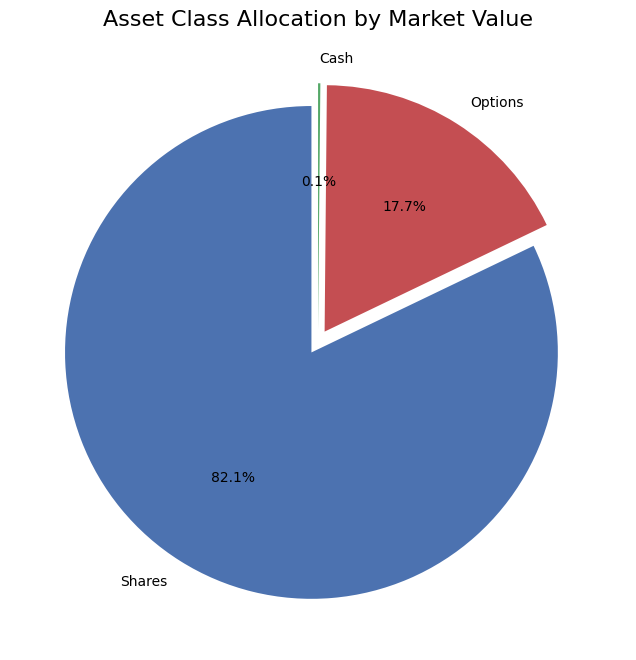

In [ ]:
def get_exchange_rate(from_currency:str,to_currency:str):
    if from_currency == to_currency:
        return 1.0
    elif to_currency == 'USD':
        ticker = f"{from_currency}=X"
    else:
        ticker = f"{from_currency}{to_currency}=X"
    price_data = yf.download(tickers=ticker, period='2d',
                             auto_adjust=True,
                             interval='1m',
                             progress=False,
                             prepost=True)

    if price_data.empty:
        print("Warning: Could not download share price data.")
        return 

    # Extract the most recent price for each ticker
    # Forward-fill to propagate the last valid price, then select the last row.
    # This handles cases where some tickers may not have traded in the last minute.
    latest_price = price_data['Close'].ffill().iloc[-1].round(decimals=3).item()
    return latest_price

def convert_currency(value, from_currency, to_currency):
    """Converts a given amount from one currency to another."""
    rate = get_exchange_rate(from_currency, to_currency)
    if rate:
        converted_amount = value * rate
        return round(converted_amount, 2)
    else:
        return None

def marketval_of_secrities_sgd(security:str,portfolio_df: pd.DataFrame) -> float:
    if security not in ['Shares', 'Options']:
        raise ValueError("Invalid security type. Must be 'Shares' or 'Options'.")
    elif security == 'Shares':
        df = portfolio_df[portfolio_df['Symbol'].str.len() <= 4]
    elif security == 'Options':
        df = portfolio_df[portfolio_df['Symbol'].str.len() > 4]
    converted_series = df.apply(
                                lambda row: convert_currency(row['Market Value'], row['Currency'], 'SGD'), axis=1
                                )
    return converted_series.sum().round(2)
shares_in_sgd = marketval_of_secrities_sgd('Shares', portfolio_df)
options_in_sgd = marketval_of_secrities_sgd('Options', portfolio_df)

 
def plot_asset_class_allocation(portfolio_df: pd.DataFrame) -> None:
    """
    Plots a bar chart showing the total market value in Shares vs. Options.
    """
    # Create a temporary 'Asset Type' column for grouping
    asset_classes = {
            'Shares': shares_in_sgd,
            'Options': options_in_sgd,
            'Cash': get_cash(acc_info),
            'Bonds': get_bond_assets(acc_info)
            }
    filtered_assets = {k: v for k, v in asset_classes.items() if v > 0}

    plt.figure(figsize=(8, 8))
    colours = ['#4c72b0', '#c44e52', '#55a868', '#8172b3', '#ccb974', '#64b5cd']
    plt.pie(
            filtered_assets.values(),
            labels=filtered_assets.keys(),
            autopct='%1.1f%%',
            startangle=90,
            explode=[0.05] * (len(filtered_assets.keys())), # Explode all slices slightly for better visibility
            colors=colours
            )
    plt.title('Asset Class Allocation by Market Value', fontsize=16)
    plt.ylabel('') # Hide the y-label as it's not needed for a pie chart
    plt.show()

plot_asset_class_allocation(portfolio_df)

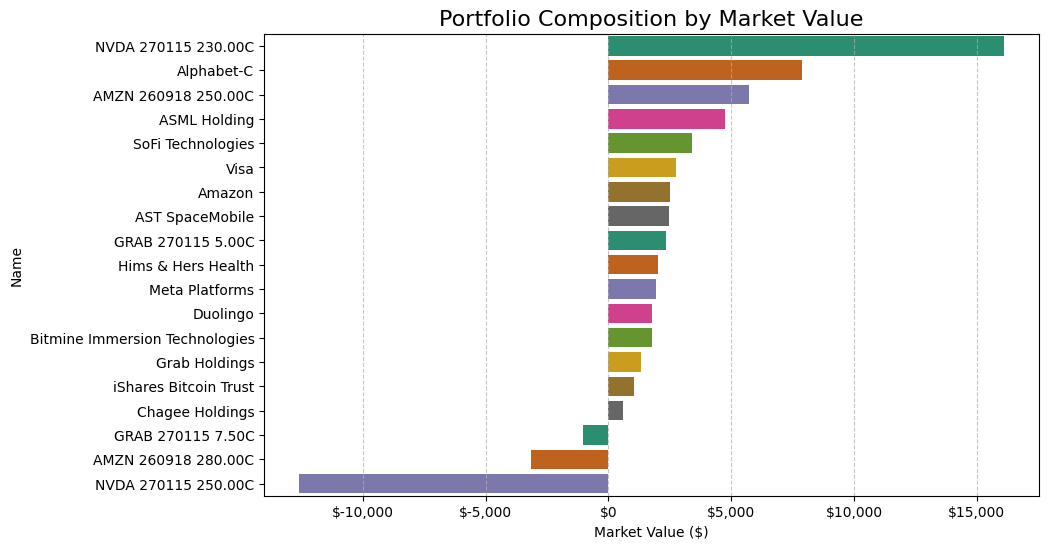

In [ ]:
def plot_portfolio_composition(portfolio_df: pd.DataFrame) -> None:
    

    # Sort by Market Value to make the chart easier to read
    sorted_df = portfolio_df.sort_values(by='Market Value', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Market Value', y='Name', data=sorted_df, hue='Name', palette='Dark2', legend=False)
    plt.title('Portfolio Composition by Market Value', fontsize=16)
    plt.xlabel('Market Value ($)')
    plt.ylabel('Name')
    plt.gca().get_xaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, p: f'${x:,.0f}')
    )
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
plot_portfolio_composition(positions)

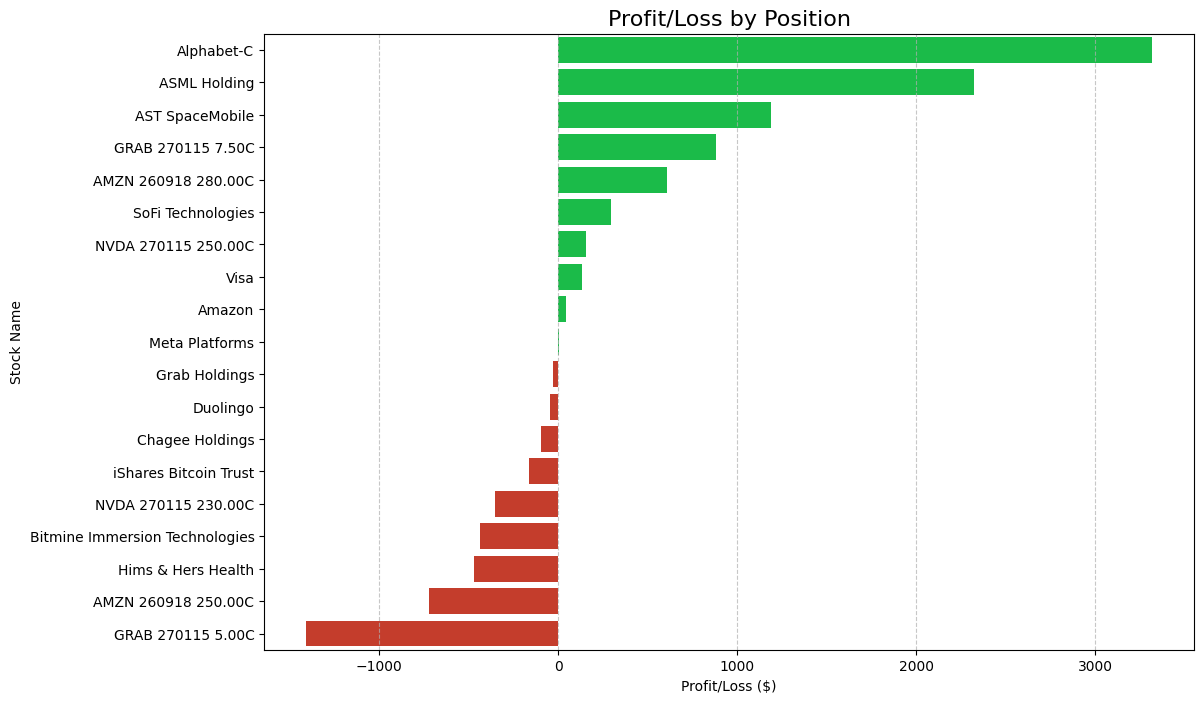

In [ ]:
def plot_pl_by_position(portfolio_df: pd.DataFrame) -> None:
    """
    Plots a bar chart showing the P/L for each position, colored by profit or loss.
    """
    # Sort by P/L for a more organized chart
    sorted_df = portfolio_df.sort_values(by='P/L', ascending=False)
    
    # Create a color palette for the bars
    colors = ["#00d63d" if x > 0 else "#dd2a13" for x in sorted_df['P/L']]
    
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='P/L',
        y='Name',
        data=sorted_df,
        hue='Name',
        palette=colors,
        legend=False
    )
    plt.title('Profit/Loss by Position', fontsize=16)
    plt.xlabel('Profit/Loss ($)')
    plt.ylabel('Stock Name')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
    
plot_pl_by_position(positions)

In [ ]:
# Use .loc to filter for 'FILLED_ALL' status and select columns in one go
historical_orders = historical_orders.loc[historical_orders['order_status'] == 'FILLED_ALL', 
                                          ['code', 'stock_name','order_market', 'trd_side','qty', 'price','currency','updated_time']]
historical_orders.rename(columns={'code': 'Symbol',
                        'stock_name':'Name',
                        'order_market':'Market',
                        'trd_side':'Buy/Sell',
                        'qty':'Quantity',
                        'price':'Current Price',
                        'currency':'Currency',
                        'updated_time':'Date & Time'}, inplace=True)
historical_orders['Symbol'] = historical_orders['Symbol'].apply(extract_ticker)
historical_orders

,Symbol,Name,Market,Buy/Sell,Quantity,Current Price,Currency,Date & Time
0,META,Meta Platforms,US,BUY,0.0016,664.94,USD,2025-12-24 03:34:59.059
1,SOFI,SoFi Technologies,US,BUY,4.0000,26.50,USD,2025-12-12 11:16:16.738
2,META,Meta Platforms,US,BUY,1.0000,670.00,USD,2025-12-05 10:45:07.428
3,BMNR,Bitmine Immersion Technologies,US,BUY,5.0000,29.30,USD,2025-12-01 11:22:26.916
4,META,Meta Platforms,US,BUY,1.0000,640.00,USD,2025-12-01 10:29:22.576
...,...,...,...,...,...,...,...,...
517,INTC,Intel,US,BUY,3.0000,31.03,USD,2024-07-03 09:30:34.574
518,NVDA,NVIDIA,US,BUY,2.0000,121.78,USD,2024-07-03 04:01:18.676
519,SE,Sea,US,SELL,1.0000,70.70,USD,2024-07-03 04:02:05.500
520,TSLA,Tesla,US,BUY,1.0000,209.89,USD,2024-07-02 04:00:57.474


In [ ]:
cashflow_filter = ['clearing_date','currency','cashflow_type','cashflow_direction','cashflow_amount','cashflow_remark']
cashflow = cashflow.loc[:, cashflow_filter]
cashflow.rename(columns={'clearing_date':'Date',
                         'currency':'Currency',
                         'cashflow_type':'Type',
                         'cashflow_direction':'IN/OUT',
                         'cashflow_amount':'Amount',
                         'cashflow_remark':'Remark'}, inplace=True)
cashflow['Amount'] = cashflow['Amount'].round(2)
cashflow
cashflow.to_csv('cashflow.csv', index=False)

,Date,Currency,Type,IN/OUT,Amount,Remark
0,2025-12-30,USD,Fund Subscription,OUT,-0.39,Fund Subscription#CSOP USD Money Market Fund
1,2025-12-29,USD,Cash Dividend,IN,0.55,BMNR 55.00000000 SHARES DIVIDENDS 0.01000000 U...
2,2025-12-29,USD,Dividend Tax,OUT,-0.16,BMNR 55.00000000 SHARES WITHHOLDING TAX -0.003...
3,2025-12-24,USD,Fund Subscription,OUT,-0.03,Fund Subscription#CSOP USD Money Market Fund
4,2025-12-23,USD,Dividend Tax,OUT,-0.47,META 3.00000000 SHARES WITHHOLDING TAX -0.1574...
...,...,...,...,...,...,...
521,2023-08-07,SGD,Others,IN,20.00,Coupon Deposit
522,2023-08-07,SGD,Others,IN,20.00,Coupon Deposit
523,2023-08-07,SGD,Others,IN,20.00,Coupon Deposit
524,2023-08-07,SGD,Others,IN,5.00,Coupon Deposit


In [23]:
cashflow.to_csv('cashflow.csv', index=False)

In [1]:
acc_info

NameError: name 'acc_info' is not defined